In [2]:
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

### Load and Examine Data

Dataset Shape: (144,)

First few entries:
Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

Data frequency: <MonthEnd>


<Figure size 1200x600 with 0 Axes>

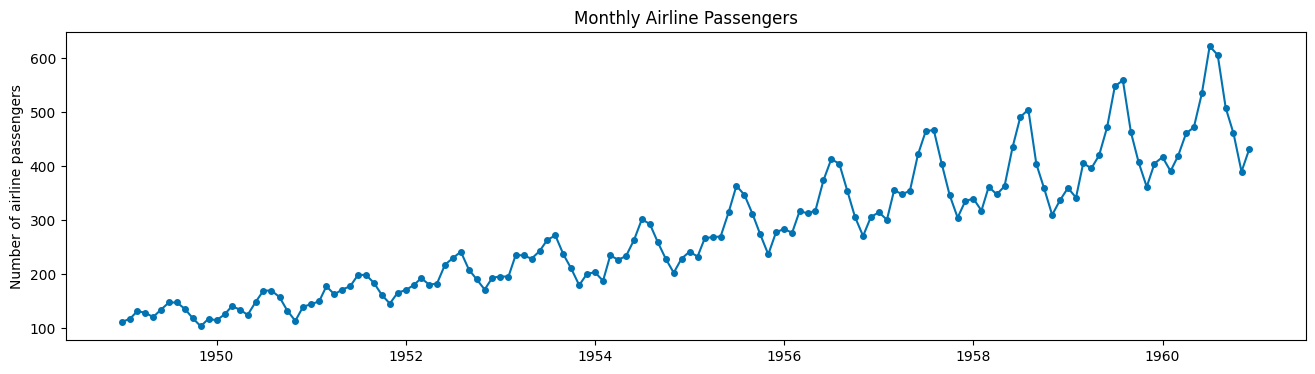

In [3]:
# Load the airline passengers dataset
y = load_airline()

# Display basic information about the dataset
print("Dataset Shape:", y.shape)
print("\nFirst few entries:")
print(y.head())
print("\nData frequency:", y.index.freq)

# Visualize the time series
plt.figure(figsize=(12, 6))
plot_series(y)
plt.title("Monthly Airline Passengers")
plt.show()

### Prepare Train/Test Split

In [4]:
# Split data into training (80%) and test (20%) sets
train_size = int(len(y) * 0.8)
y_train = y[:train_size]
y_test = y[train_size:]

# Define forecasting horizon
fh = np.arange(1, len(y_test) + 1)

print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Forecasting horizon: {len(fh)} steps")

Training set size: 115
Test set size: 29
Forecasting horizon: 29 steps


### Simple Variance Forecasting

First few variance predictions:
                   0
1958-08  10547.36861
1958-09  10547.36861
1958-10  10547.36861
1958-11  10547.36861
1958-12  10547.36861


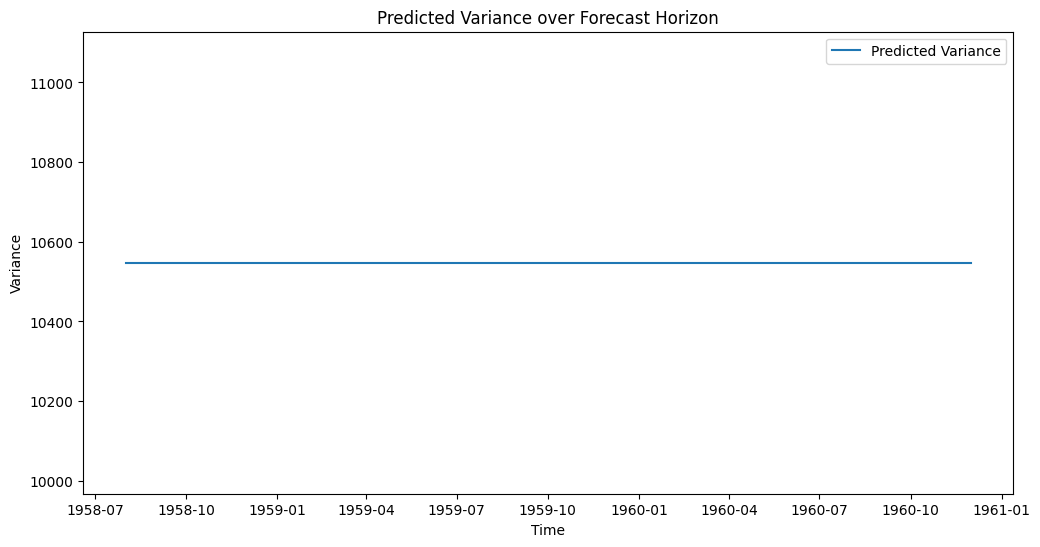

In [8]:
# Initialize and fit the forecaster
forecaster = NaiveForecaster(strategy="mean", sp=12)  # sp=12 for monthly seasonal data
forecaster.fit(y_train)

# Generate variance predictions
variance_pred = forecaster.predict_var(fh=fh)

print("First few variance predictions:")
print(variance_pred.head())

# Convert PeriodIndex to DatetimeIndex for plotting
variance_pred.index = variance_pred.index.to_timestamp()

# Visualize the variance predictions
plt.figure(figsize=(12, 6))
plt.plot(variance_pred.index, variance_pred.values, label="Predicted Variance")
plt.title("Predicted Variance over Forecast Horizon")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.legend()
plt.show()

### Prediction Intervals

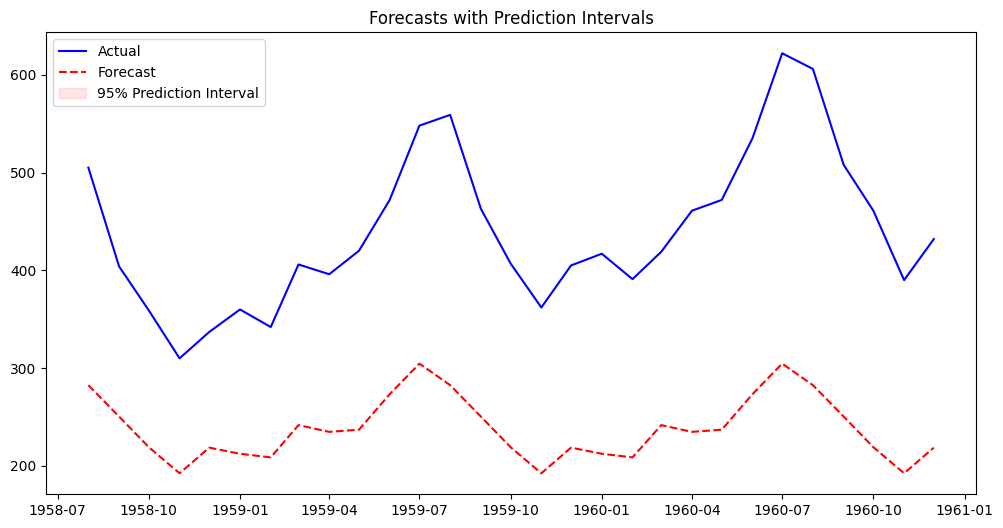

In [15]:
# Calculate point predictions
y_pred = forecaster.predict(fh=fh)

# Calculate prediction intervals using variance
z_score = 1.96  # for 95% confidence interval
std_dev = np.sqrt(
    variance_pred[0]
)  # Extract the variance values and calculate standard deviation
prediction_intervals = pd.DataFrame(
    {"lower": y_pred - z_score * std_dev, "upper": y_pred + z_score * std_dev},
    index=y_pred.index,
)

y_pred.index = y_pred.index.to_timestamp()
y_test.index = y_test.index.to_timestamp()

# Plot predictions with intervals
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, "b-", label="Actual")
plt.plot(y_pred.index, y_pred.values, "r--", label="Forecast")
plt.fill_between(
    prediction_intervals.index,
    prediction_intervals["lower"],
    prediction_intervals["upper"],
    color="r",
    alpha=0.1,
    label="95% Prediction Interval",
)
plt.title("Forecasts with Prediction Intervals")
plt.legend()
plt.show()

### Variance Forecasting with Covariance

Shape of variance-covariance matrix: (29, 29)


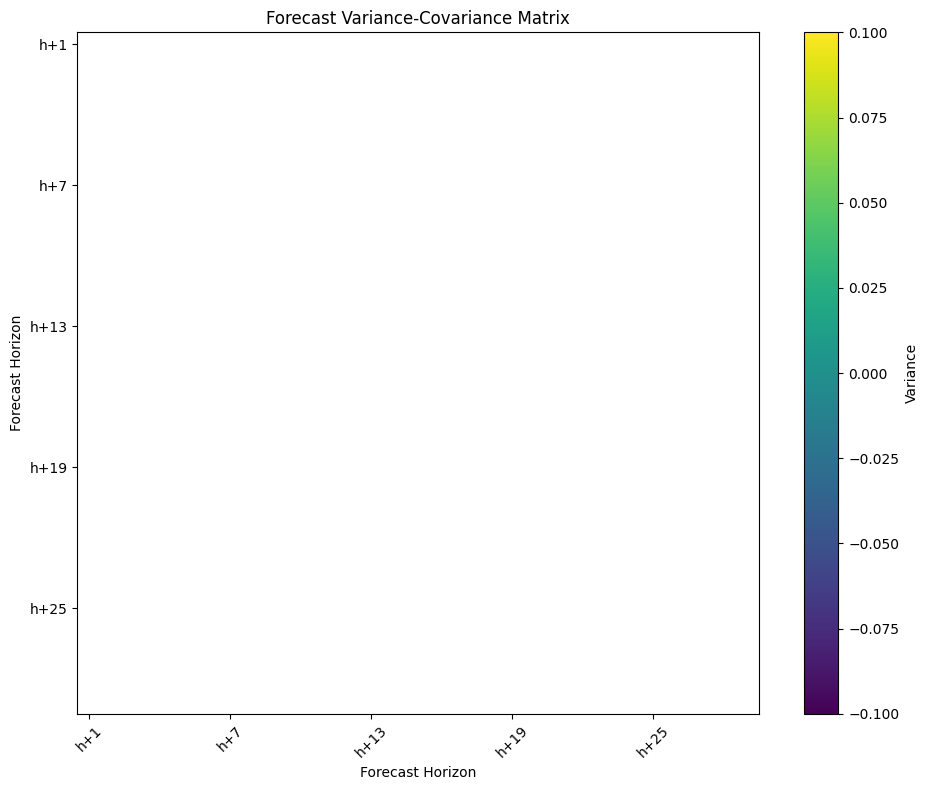

In [22]:
# Generate variance-covariance matrix predictions
variance_cov = forecaster.predict_var(fh=fh, cov=True)


# Convert to numeric matrix
variance_cov_matrix = variance_cov.astype(float)

print("Shape of variance-covariance matrix:", variance_cov_matrix.shape)

# Visualize the covariance matrix
plt.figure(figsize=(10, 8))
plt.imshow(variance_cov_matrix, cmap="viridis")
plt.colorbar(label="Variance")
plt.title("Forecast Variance-Covariance Matrix")
plt.xlabel("Forecast Horizon")
plt.ylabel("Forecast Horizon")

# Add ticks every 6 months for better readability
tick_positions = np.arange(0, len(fh), 6)
tick_labels = [f"h+{i+1}" for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.yticks(tick_positions, tick_labels)

plt.tight_layout()
plt.show()

### Evaluation of Variance Forecasts

In [23]:
# Set up cross-validation
cv = ExpandingWindowSplitter(
    initial_window=60,
    step_length=1,
    fh=np.arange(1, 13),  # 12-step ahead forecasts
)

# Evaluate the forecasts
results = evaluate(forecaster=forecaster, y=y, cv=cv, return_data=True)

print("\nEvaluation Results:")
print(results.head())


Evaluation Results:
   test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                          0.277988  0.005053   0.004462                60   
1                          0.284243  0.002646   0.003729                61   
2                          0.295400  0.001666   0.003720                62   
3                          0.299811  0.001796   0.002695                63   
4                          0.306460  0.001468   0.003249                64   

    cutoff                                            y_train  \
0  1953-12  1949-01    112.0
1949-02    118.0
1949-03    1...   
1  1954-01  1949-01    112.0
1949-02    118.0
1949-03    1...   
2  1954-02  1949-01    112.0
1949-02    118.0
1949-03    1...   
3  1954-03  1949-01    112.0
1949-02    118.0
1949-03    1...   
4  1954-04  1949-01    112.0
1949-02    118.0
1949-03    1...   

                                              y_test  \
0  1954-01    204.0
1954-02    188.0
1954-03    2...   
1  1954

### Comparing Forecasting Methods

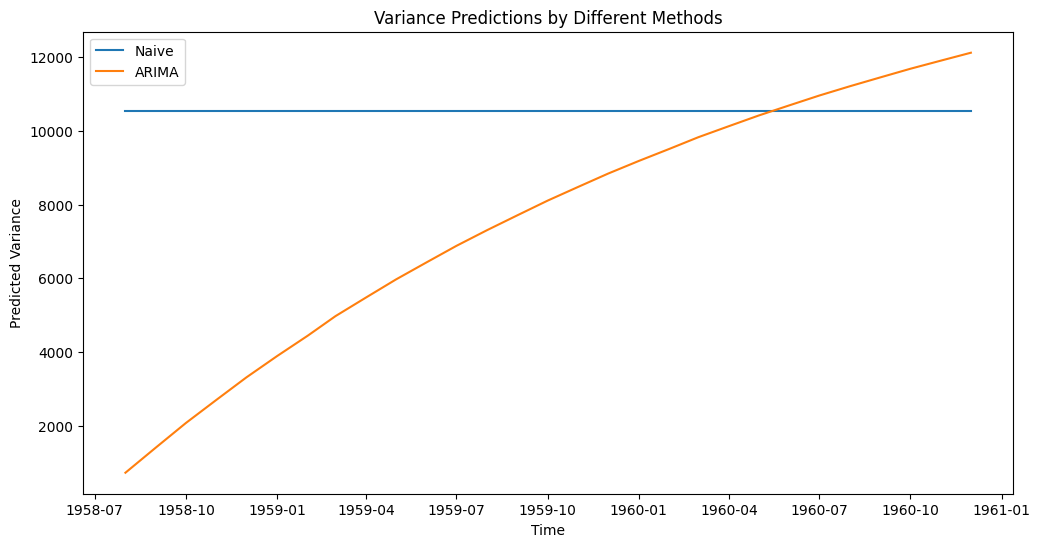

In [27]:
from sktime.forecasting.arima import ARIMA

# Initialize different forecasters
forecasters = {
    "Naive": NaiveForecaster(strategy="mean", sp=12),
    "ARIMA": ARIMA(suppress_warnings=True),
}

# Compare variance predictions
plt.figure(figsize=(12, 6))

for name, forecaster in forecasters.items():
    forecaster.fit(y_train)
    var_pred = forecaster.predict_var(fh=fh)
    var_pred.index = var_pred.index.to_timestamp()
    plt.plot(var_pred.index, var_pred.values, label=name)

plt.title("Variance Predictions by Different Methods")
plt.xlabel("Time")
plt.ylabel("Predicted Variance")
plt.legend()
plt.show()